In [ ]:
%%capture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN
from datetime import datetime, timedelta
from collections.abc import Iterable
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import pandas as pd
import tracemalloc
import numpy as np
import warnings
import random
import shutil
import timeit
import psutil
import time
import pdb
import sys
import re
import os
import csv

warnings.filterwarnings("ignore")

In [ ]:
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / (1024 ** 2)  # in MB
tracemalloc.start()

In [ ]:
# Define global constants for various settings

# CONSUMPTION_RANGES = [
#     [0, 14428.0],      # Range 1: from 0 to 14428.0
#     [14430.0, 17532.0],# Range 2: from 14430.0 to 17532.0
#     [17535.0, float('inf')]  # Range 3: from 17535.0 to infinity
# ]

CSV_FILE_PATHS=['./dataset/AEP_hourly.csv','./dataset/electricityConsumptionAndProductioction.csv','./dataset/Load Consumption Data Algeria.csv']

 
 
CSV_FILE_PATH = './dataset/Load Consumption Data Algeria.csv'  # The path where the long-format data will be saved
TIME_COLUMN = 'DateTime'  # Column name for datetime data
CONSUMPTION_COLUMN = 'Consumption'  # Column name for consumption data
COLUMNS_TO_KEEP = [TIME_COLUMN, CONSUMPTION_COLUMN]

NUM_SEARCH_COUNT=1


DEFAULT_DATE_FORMAT = '%Y-%m-%d %H:%M'  # Default format for date and time


In [ ]:
import os

base_folder_name = os.path.splitext(os.path.basename(CSV_FILE_PATH))[0]

folder_name = "./output/"+base_folder_name 

os.makedirs(folder_name, exist_ok=True)
os.makedirs(folder_name+"/search intervals", exist_ok=True)
# folder_name = folder_name+"/data_groups.csv"

# output_file_path = os.path.join(folder_name, 'data_groups.csv')
print(folder_name)

In [ ]:
import pandas as pd
import os

def rename_columns_in_csv(file_path, rename_dict, save_path=None, overwrite=True):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    df = pd.read_csv(file_path)
    df.rename(columns=rename_dict, inplace=True)
    print(df.columns)
    df=df[COLUMNS_TO_KEEP]
    if overwrite:
        save_path = file_path  # Overwrite the original file
    elif save_path is None:
        raise ValueError("save_path must be provided if overwrite is False.")
    
    df.to_csv(save_path, index=False)
    print(f"CSV file saved to {save_path} successfully!")


In [ ]:
import pandas as pd

def compare_time_intervals_fixed_step(csv_paths, time_column):
    comparison_data = []

    for path in csv_paths:
        dataset_name = path.split('/')[-1].replace('.csv', '')

        df = pd.read_csv(path)

        df[time_column] = pd.to_datetime(df[time_column])

        first_time = df[time_column].min()
        last_time = df[time_column].max()

        total_data_points = df[time_column].count()

        comparison_data.append({
            'Dataset': dataset_name,
            'First Time': first_time,
            'Last Time': last_time,
            'Total Data Points': total_data_points,
            'Time Step': '1h 0m 0s'
        })

    comparison_df = pd.DataFrame(comparison_data)

    comparison_df = comparison_df.sort_values(by='Total Data Points', ascending=False)

    return comparison_df


comparison_table = compare_time_intervals_fixed_step(CSV_FILE_PATHS, TIME_COLUMN)

display(comparison_table)


In [ ]:
def save_dataframe_to_csv(dataframe, file_path):
    directory = os.path.dirname(file_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
    
    dataframe.to_csv(file_path, index=False)
    print(f"DataFrame saved successfully to {file_path}")

file_path = './output/comparison_data_frames.csv'

save_dataframe_to_csv(comparison_table, file_path)


In [ ]:
def check_gpu_availability():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print('\n\nError: Configure notebook to use a GPU.')
        raise SystemError('GPU device not found')
    print('GPU is available and configured.')

def check_tensorflow_version_and_gpus():
    print("TensorFlow version:", tf.__version__)
    print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

def cpu_operation():
    """Perform a convolution operation on the CPU."""
    with tf.device('/cpu:0'):
        random_image_cpu = tf.random.normal((100, 100, 100, 3))
        net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
        return tf.math.reduce_sum(net_cpu)

def gpu_operation():
    """Perform a convolution operation on the GPU."""
    with tf.device('/device:GPU:0'):
        random_image_gpu = tf.random.normal((100, 100, 100, 3))
        net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
        return tf.math.reduce_sum(net_gpu)

def measure_performance():
    """Measure and print the performance of CPU and GPU operations."""
    print('CPU (s): ' + str(timeit.timeit('cpu_operation()', number=10, setup="from __main__ import cpu_operation")))
    print('GPU (s): ' + str(timeit.timeit('gpu_operation()', number=10, setup="from __main__ import gpu_operation")))


In [ ]:
# Execution
try:
    check_gpu_availability()
    check_tensorflow_version_and_gpus()
    measure_performance()
except SystemError as e:
    print(f"Error: {e}")
    # Handle the exception or provide instructions to the user
    print("Please configure your environment to use a GPU.")


In [ ]:
def read_and_sort_csv_by_time(file_path, time_column):
    """Read a CSV file and sort it by the specified time column."""
    
    # Read the CSV file into a DataFrame
    all_df = pd.read_csv(CSV_FILE_PATH)

    df = pd.read_csv(file_path)
    
    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    duplicates = df[df.duplicated(subset=time_column, keep=False)]
    df_unique = df.drop_duplicates(subset=time_column, keep='first')

    # Sort the DataFrame by the time column
    df_sorted = df.sort_values(by=time_column)
    
    return df_sorted

def rename_columns(df, consumption_column='AEP_MW', time_column='Datetime', new_consumption_name=CONSUMPTION_COLUMN, new_time_name=TIME_COLUMN):
    # Renames specified columns in the DataFrame.
    if consumption_column in df.columns:
        df.rename(columns={consumption_column: new_consumption_name}, inplace=True)
    if time_column in df.columns:
        df.rename(columns={time_column: new_time_name}, inplace=True)
    return df

def filter_dataframe(df, fraction=10):
    df = df.copy()
    df=df[:len(df)//10]
    return df

def keep_columns(df, columns_to_keep):
    df = df[columns_to_keep]
    return df

def format_date_column(df):
    df[TIME_COLUMN] = pd.to_datetime(df[TIME_COLUMN])
    df[TIME_COLUMN] = df[TIME_COLUMN].dt.strftime('%Y-%m-%d %H:%M')
    return df

def scale_consumption_data(df):
    # Reshape CONSUMPTION_COLUMN data
    X = df[CONSUMPTION_COLUMN].values.reshape(-1, 1)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, scaler

In [ ]:

all_df = read_and_sort_csv_by_time(CSV_FILE_PATH, TIME_COLUMN)
all_df = all_df.reset_index(drop=True)

# print(all_df.head())

# all_df = rename_columns(all_df, CONSUMPTION_COLUMN, TIME_COLUMN)  # Initial DataFrame setup

all_df = format_date_column(all_df)  # Format date column

df = filter_dataframe(all_df,5)  # Filter DataFrame to 10% of original

# df = keep_columns(df, COLUMNS_TO_KEEP)  # Keep specific columns

X_scaled, scaler = scale_consumption_data(df)  # Apply scaling to the 'consumption' data

display(df)

In [ ]:
import pandas as pd

def transform_wide_to_long(input_file: str, output_file: str) -> pd.DataFrame:
    # Read the wide-format Excel file
    df = pd.read_excel(input_file)
    
    rename_dict = {f'{i+1}h': f'{i}h' for i in range(25)}
    df.rename(columns=rename_dict, inplace=True)
    # df = df.rename(columns={"24h": "0h"})
    # Melt the DataFrame from wide to long format
    # print(df.columns)
    df_long = df.melt(id_vars=['Date'], var_name='Hour', value_name=CONSUMPTION_COLUMN)

    # Convert Date column to string
    df_long['Date'] = df_long['Date'].astype(str)

    # Convert Hour to the proper time format
    df_long['Hour'] = df_long['Hour'].str.replace('h', ':00')

    # Combine Date and Hour into "date and time", infer format if necessary
    df_long[TIME_COLUMN] = pd.to_datetime(df_long['Date'] + ' ' + df_long['Hour'], errors='coerce')

    # Drop rows with invalid dates (if any)
    df_long = df_long.dropna(subset=[TIME_COLUMN])

    # Drop unnecessary columns
    df_long = df_long[[TIME_COLUMN, CONSUMPTION_COLUMN]]

    # Sort by date and time
    df_long = df_long.sort_values(by=TIME_COLUMN)

    # Reset index
    df_long = df_long.reset_index(drop=True)

    # Save the long-format DataFrame to a new CSV file
    df_long.to_csv(output_file, index=False)

    return df_long


In [ ]:

# # Example usage
# file_path = './Labstic/BDD_E.xlsx'  # Replace with your actual file path
# output_path = './Labstic/converted_dataset.csv'  # The path where the long-format data will be saved
# transformed_df = transform_wide_to_long(file_path, output_path)
# display(transformed_df.head())

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'



def calc_consumption_ranges(df, X_scaled, k=3):
    df['cluster'] = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    consumption_ranges = df.groupby('cluster')[CONSUMPTION_COLUMN].agg(['min', 'max']).sort_values('min').values.tolist()
    consumption_ranges[0][0], consumption_ranges[-1][1] = 0, float('inf')
    unique_consumption_levels = [0] + [r[1] for r in consumption_ranges[:-1]]
    return consumption_ranges, unique_consumption_levels
def plot_clusters(df, X_scaled, k=3, filename='clusters_plot.pdf'):
    # Perform clustering using the method already defined
    calc_consumption_ranges(df, X_scaled, k)
    
    # Define the more beautiful colors for the clusters
    cluster_colors = ['#4CAF50', '#FFB74D', '#81D4FA']  # Beautiful colors in the same family

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 10))  # Set figure size to 20 width by 10 height

    # Initialize variables to determine y-axis limits
    min_y = float('inf')
    max_y = float('-inf')

    # Plot the clusters with different colors
    for cluster in range(k):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(cluster_data.index, cluster_data[CONSUMPTION_COLUMN], label=f'Cluster {cluster}', 
                   color=cluster_colors[cluster], alpha=0.6, edgecolors='black', s=50)

        # Update y-axis limits
        min_y = min(min_y, min(cluster_data[CONSUMPTION_COLUMN]))
        max_y = max(max_y, max(cluster_data[CONSUMPTION_COLUMN]))

    # Add labels, title, and legend
    ax.set_title('Clusters of Consumption Data', fontsize=20, pad=20)
    ax.set_xlabel('DateTime', fontsize=20, labelpad=20)
    ax.set_ylabel(CONSUMPTION_COLUMN, fontsize=20, labelpad=20)

    ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust the size of the tick labels
    ax.tick_params(axis='both', which='both', labelcolor='black')  # Optional: Customize tick label color
    ax.legend(fontsize=15, loc='upper left')  # Add legend with adjusted font size

    # Set y-axis limits to fit the data
    buffer = (max_y - min_y) * 0.1  # Add some buffer space
    ax.set_ylim(min_y - buffer, max_y + buffer)

    # Add grid to the plot
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Grid with dashed lines

    # Set the x-ticks to correspond to time stamps
    # Convert 'DateTime' to datetime if it's not already
    ax.set_xticks(df.index[::int(len(df) / 10)])  # Choose a subset of x-ticks, adjust as needed
    ax.set_xticklabels(pd.to_datetime(df['DateTime']).iloc[::int(len(df) / 10)].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=45, ha='right')
    ax.grid(False)

    # Save the plot as a vectorial PDF
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close()

In [ ]:
df

In [ ]:
print(df.columns)


In [ ]:
CONSUMPTION_RANGES, LEVEL_SEPARATORS = calc_consumption_ranges(df, X_scaled)
print(CONSUMPTION_RANGES)
print(LEVEL_SEPARATORS)

plot_clusters(df, X_scaled, k=3, filename='clusters_plot.pdf')


In [ ]:
def save_ranges_and_separators_to_csv(consumption_ranges, level_separators, input_csv_path):
    # Construct the output directory and file path
    output_dir = f"./output/{os.path.splitext(os.path.basename(input_csv_path))[0]}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, 'consumption_ranges_and_separators.csv')

    # Prepare data for saving
    consumption_ranges_df = pd.DataFrame({"CONSUMPTION_RANGES": [str(r) for r in consumption_ranges]})
    level_separators_df = pd.DataFrame({"LEVEL_SEPARATORS": level_separators})
    
    # Concatenate the two DataFrames, aligning them vertically
    combined_df = pd.concat([consumption_ranges_df, level_separators_df], axis=1)
    
    # Save to CSV
    combined_df.to_csv(output_file_path, index=False)
    print(f"Ranges and separators saved successfully to {output_file_path}")


# Save the data
save_ranges_and_separators_to_csv(CONSUMPTION_RANGES, LEVEL_SEPARATORS, CSV_FILE_PATH)


In [ ]:
class TreeNode():
    def __init__(self):
        self.left = None
        self.right = None
        self.key = None

class LeafNode():
    def __init__(self):
        # super().__init__()
        self.left = None
        self.right = None
        self.key = None
        self.data = []
        self.level = None
        self.timeRange = None


In [ ]:
def Insert (c,pt,father):
  global p,root
  if not c:
    print("empty")
  else:
    if p is None :
      p = LeafNode()
      p.data=c
      p.timeRange=[c[0][1],c[len(c)-1][1]]
      p.key=c[0][1]
      p.level=level(c)

    else:
      if pt.level > level(c) :
        if pt.right is None:
          pt.right = LeafNode()
          pt.right.timeRange=[c[0][1],c[len(c)-1][1]]
          pt.right.key=c[0][1]
          pt.right.data=c
          pt.right.level=level(c)

        else:
          Insert(c,pt.right,True)
      elif pt.level < level(c) :
        # pdb.set_trace()
        if father == False:
          t = LeafNode()
          t.timeRange=[c[0][1],c[len(c)-1][1]]
          t.key=c[0][1]
          t.data=c
          t.level=level(c)
          t.left = p
          p = t
        else:
          t = TreeNode()
          t.key= get_first_time(p)
          t.left = root
          t.right = p
          root = t

          p=LeafNode()
          p.timeRange=[c[0][1],c[len(c)-1][1]]
          p.key=c[0][1]
          p.data=c
          p.level=level(c)
      elif pt.level == level(c) :  # 000
        t = TreeNode()
        t.key= get_first_time(p)
        t.left = root
        t.right = p
        root = t

        p=LeafNode()
        p.timeRange=[c[0][1],c[len(c)-1][1]]
        p.key=c[0][1]
        p.data=c
        p.level=level(c)

In [ ]:
def get_total_size(obj, seen=None):  # Recursively find the total size of an object including its members. 
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()

    obj_id = id(obj)
    if obj_id in seen:
        return 0

    # Mark this object as seen
    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum([get_total_size(v, seen) for v in obj.values()])
        size += sum([get_total_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_total_size(obj.__dict__, seen)
    elif isinstance(obj, Iterable) and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_total_size(i, seen) for i in obj])

    return size

def get_first_time(tree):
  if tree.left is  None:
    return tree.data[0][1]
  else: return get_first_time(tree.left)

def get_last_time(tree):
  if tree.right is None:
    return tree.data[len(tree.data)-1][1]
  else: return get_first_time(tree.right)

def time_range(tree):
  return (get_first_time(tree),get_last_time(tree))

def allData(tree):
  dataListe=[]
  if tree.left is not None:
    dataListe+=allData(tree.left)
  if isinstance(tree,LeafNode):
    dataListe+=tree.data
  if tree.right is not None:
    dataListe+=allData(tree.right)
  return(dataListe)

def get_consumption_level(input_value, CONSUMPTION_RANGES):
  for level, (start, end) in enumerate(CONSUMPTION_RANGES): # Iterate through consumption ranges to find the level
    if start <= input_value <= end:
      return level+1
  return -1      # If input doesn't match any level, return -1 or handle accordingly

def level(data):
  if data is not None:
#     print(data)
    return get_consumption_level(data[0][0],CONSUMPTION_RANGES)
  else:
    return False

def add_to_cluster(input_value,date_time,consumptionLevel):
  if consumptionLevel <= len(CONSUMPTION_RANGES):    # Check if the input value falls within the specified consumption level
    start, end = CONSUMPTION_RANGES[consumptionLevel-1]
    if start <= input_value <= end:
      cluster.append((input_value,date_time) )     # If it does, add it to the last cluster with the current system time
      return True
  return False

timeRange = lambda cluster: (min((time for _, time in cluster), default=None), max((time for _, time in cluster), default=None))


In [ ]:
def countDataPointInTree(tree):
  cnt=0 # Initialize the count variable
  if isinstance(tree, TreeNode):
    if tree.left is not None:  # Recursively count data points in the left subtree if exist
      cnt+=countDataPointInTree (tree.left)
    if tree.right is not None:  # Recursively count data points in the right subtree if exist
      cnt+=countDataPointInTree (tree.right)
  else:
    cnt+= len(tree.data) # Count the number of data points in the node
    if tree.left is not None:
      cnt+=countDataPointInTree (tree.left)
    if tree.right is not None:
      cnt+=countDataPointInTree (tree.right)
  return cnt

def countTotalNode(tree):
  cnt=1 # Initialize the count variable
  if tree.left is not None:
    cnt+=countTotalNode (tree.left)
  if tree.right is not None:
    cnt+=countTotalNode (tree.right)
  return cnt

def countArtificialNode(tree):
  cnt=0 # Initialize the count variable
  if isinstance(tree, TreeNode):
    cnt+=1
    if tree.left is not None:
      cnt+=countArtificialNode (tree.left)
    if tree.right is not None:
      cnt+=countArtificialNode (tree.right)
  elif isinstance(tree, LeafNode):
    if tree.left is not None:
      cnt +=countArtificialNode(tree.left)
    if tree.right is not None:
      cnt +=countArtificialNode(tree.right)
  return cnt

def countRealNode(tree):
  cnt=0 # Initialize the count variable
  if isinstance(tree, TreeNode):
    if tree.left is not None:
      cnt+=countRealNode (tree.left)
    if tree.right is not None:
      cnt+=countRealNode (tree.right)
  elif isinstance(tree, LeafNode):
    cnt+=1
    if tree.left is not None:
      cnt +=countRealNode(tree.left)
    if tree.right is not None:
      cnt +=countRealNode(tree.right)
  return cnt

def countClustersInLeaf(tree):
  def countInLeaf(tree):
    cnt=1
    if tree.left is not None:
      cnt+=countInLeaf (tree.left)
    if tree.right is not None:
      cnt+=countInLeaf (tree.right)
    return cnt
  dataInLeafs=[]
  if isinstance(tree, TreeNode):
    if tree.left is not None: # Recursively count clusters in the left subtree if exist
      if isinstance(tree.left, LeafNode):
        dataInLeafs.append(countInLeaf(tree.left))
      else:
        dataInLeafs=dataInLeafs+countClustersInLeaf (tree.left)
    if tree.right is not None:  # Recursively count clusters in the right subtree if exist
      if isinstance(tree.right, LeafNode):
        dataInLeafs.append(countInLeaf(tree.right))
      else:
        dataInLeafs=dataInLeafs+countClustersInLeaf(tree.right)
  return dataInLeafs

def displayAllData(tree):
  cnt=0 # Initialize the count variable
  if isinstance(tree, TreeNode):
    if tree.left is not None:  # Recursively count data points in the left subtree if exist
      displayAllData (tree.left)
    if tree.right is not None:  # Recursively count data points in the right subtree if exist
      displayAllData (tree.right)
  else:
    # Add the count to the total count
    if tree.left is not None:
      displayAllData (tree.left)
    print(tree.data) # Count the number of data points in the node
    if tree.right is not None:
      displayAllData (tree.right)

def sizeof_tree(node):
    totalsite= 0
    if node is None:
        return 0
    elif isinstance(node,LeafNode):
      totalsite+= sys.getsizeof(node) + sizeof_tree(node.left) + sizeof_tree(node.right) +sys.getsizeof(node.key)+sys.getsizeof(node.data)+sys.getsizeof(node.timeRange)+sys.getsizeof(node.level)
    elif isinstance(node,TreeNode):
      totalsite+= sys.getsizeof(node) + sizeof_tree(node.left) + sizeof_tree(node.right) +sys.getsizeof(node.key)
    return totalsite

def countNodesInConsumptionLevel(tree,n):
  dataInLeafs=[]
  if isinstance(tree, TreeNode):
    if tree.left is not None: # Recursively count clusters in the left subtree if exist
      dataInLeafs=dataInLeafs+countNodesInConsumptionLevel (tree.left,n)
    if tree.right is not None:  # Recursively count clusters in the right subtree if exist
      dataInLeafs=dataInLeafs+countNodesInConsumptionLevel(tree.right,n)
  else:
    if tree.level==n:
      dataInLeafs.append(len(tree.data))
    if tree.left is not None: # Recursively count clusters in the left subtree if exist
      dataInLeafs=dataInLeafs+countNodesInConsumptionLevel (tree.left,n)
    if tree.right is not None:  # Recursively count clusters in the right subtree if exist
      dataInLeafs=dataInLeafs+countNodesInConsumptionLevel(tree.right,n)
  return dataInLeafs

def display_node_distribution(root):
    cntDataBotLevelTree=countClustersInLeaf(root)
    counter = Counter(cntDataBotLevelTree)
    total_nodes = sum(key * value for key, value in counter.items())

    # Convert Counter to DataFrame
    df = pd.DataFrame.from_dict(counter, orient='index', columns=['Node Count'])
    df.index.name = 'Level'
    
    # Sort the DataFrame by level
    df.sort_index(inplace=True)
    
    # Display the table
    print("Table of Node Distribution:")
    print(df)
    
    # Plot the distribution for all levels
    plt.figure(figsize=(6, 4))
    plt.bar(df.index, df['Node Count'], color='skyblue')
    plt.title('Distribution of Cluster Counts in Bot Level Trees')
    plt.xlabel('Number of Nodes in Bot Level Tree')
    plt.ylabel('Occurrences')
    plt.xticks(df.index)
    plt.show()
    
    # Display the total filled nodes
    print(f"\nTotal filled nodes: {total_nodes}")

def process_consumption_levels(root, levels):
    result_dict = {}
    dictionnair = []
    
    for i in range(1,len(CONSUMPTION_RANGES)+1):
        values = countNodesInConsumptionLevel(root, i)  # Assuming this function is defined elsewhere
        count_values = Counter(values)
        
        print("\n Consumption level %s :" % i)
        dictionnair.append(dict(count_values))
        print(dictionnair[i-1])
        
        # Sum of all data points in this consumption level
        total_data_points = sum(key * value for key, value in count_values.items())
        print("Number of DataPoints in Consumption level %s : %s" % (i, total_data_points))
        
        # Sum of all nodes in this consumption level
        total_nodes = sum(count_values.values())
        print("Number of Nodes in Consumption level %s : %s" % (i, total_nodes))
        
        # Add results to the overall result dictionary
        for key, value in count_values.items():
            result_dict[key] = result_dict.get(key, 0) + value
    
    # Store and print the aggregated result for all data
    final_dict = dict(sorted(result_dict.items()))
    dictionnair.append(final_dict)
    print("\n  For all data: %s" % final_dict)
    
    return dictionnair

def plot_schematic(dictionnair):
    levels = len(dictionnair)
    all_keys = sorted(set().union(*(d.keys() for d in dictionnair)))
    
    # Create a matrix where rows correspond to levels and columns to keys
    data_matrix = np.zeros((levels, len(all_keys)))
    key_to_index = {key: idx for idx, key in enumerate(all_keys)}
    
    for i, data in enumerate(dictionnair):
        for key, value in data.items():
            data_matrix[i, key_to_index[key]] = value
    
    # Adjust figure size to be very wide
    fig, ax = plt.subplots(figsize=(25, 10))
    bar_width = 0.8 / levels
    index = np.arange(len(all_keys))
    
    # Plot bars for each level side by side
    for i in range(levels):
        ax.bar(index + i * bar_width, data_matrix[i], bar_width,
               color=plt.get_cmap('tab10').colors[i % len(plt.get_cmap('tab10').colors)],
               label=f'Level {i + 1}')
    
    # Customize the plot
    ax.set_xlabel('Data Point Length', fontsize=25)
    ax.set_ylabel('Number of Tree Nodes', fontsize=25)
    ax.set_title('Schematic of Consumption Levels', fontsize=30)
    ax.set_xticks(index + bar_width * (levels / 2))
    ax.set_xticklabels(all_keys, rotation=45, ha='right')
    ax.legend(fontsize=25)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_schematic_ignore_small_values(dictionnair, threshold=50):
    levels = len(dictionnair)
    all_keys = sorted(set().union(*(d.keys() for d in dictionnair)))
    
    # Create a matrix where rows correspond to levels and columns to keys
    data_matrix = np.zeros((levels, len(all_keys)))
    key_to_index = {key: idx for idx, key in enumerate(all_keys)}
    
    for i, data in enumerate(dictionnair):
        for key, value in data.items():
            data_matrix[i, key_to_index[key]] = value
    
    # Calculate the total number of tree nodes for each key
    total_nodes = np.sum(data_matrix, axis=0)
    
    # Filter out keys where the total is less than the threshold
    valid_keys = [key for key, total in zip(all_keys, total_nodes) if total >= threshold]
    valid_indices = [key_to_index[key] for key in valid_keys]
    
    # Filter the data matrix to only include valid keys
    filtered_data_matrix = data_matrix[:, valid_indices]
    
    # Adjust figure size to be very wide
    fig, ax = plt.subplots(figsize=(25, 10))
    bar_width = 0.8 / levels
    index = np.arange(len(valid_keys))
    
    # Plot bars for each level side by side
    for i in range(levels):
        ax.bar(index + i * bar_width, filtered_data_matrix[i], bar_width,
               color=plt.get_cmap('tab10').colors[i % len(plt.get_cmap('tab10').colors)],
               label=f'Level {i + 1}')
    
    # Customize the plot
    ax.set_xlabel('Data Point Length', fontsize=25)
    ax.set_ylabel('Number of Tree Nodes', fontsize=25)
    ax.set_title(f'Schematic of Consumption Levels (Threshold: {threshold})', fontsize=30)
    ax.set_xticks(index + bar_width * (levels / 2))
    ax.set_xticklabels(valid_keys, rotation=45, ha='right', fontsize=25)
    ax.legend(fontsize=25)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()


In [ ]:
def get_range_index(consumption):
    for i, (start, end) in range_dict.items():
        if start <= consumption <= end:
            return i

def group_consumption_ranges(df, CONSUMPTION_RANGES):

    for i, (start, end) in enumerate(CONSUMPTION_RANGES):
        range_dict[i] = (start, end)


    df['range_index'] = df[CONSUMPTION_COLUMN].apply(get_range_index)

    groups = []
    current_group = []
    prev_index = None
    for index, row in df.iterrows():
        if prev_index is None:
            current_group.append((row[CONSUMPTION_COLUMN], row[TIME_COLUMN]))
        elif row['range_index'] == prev_index:
            current_group.append((row[CONSUMPTION_COLUMN], row[TIME_COLUMN]))
        else:
            groups.append(current_group)
            current_group = [(row[CONSUMPTION_COLUMN], row[TIME_COLUMN])]
        prev_index = row['range_index']

    if current_group:
        groups.append(current_group)

    return groups

def filter_groups_by_length(groups, n):
  filtered_groups = [group for group in groups if len(group) >= n]
  return filtered_groups

def merge_groups_within_ranges(filtered_groups, consumption_ranges, get_range_index):
    merged_groups = []
    merged_groups.append(filtered_groups[0])  # Initialize merged_groups with the first group
    for group in filtered_groups[1:]:  # Iterate through the rest of the filtered_groups
        current_range_index = get_range_index(group[0][0])  # Get the consumption range index for the current group
        last_merged_range_index = get_range_index(merged_groups[-1][-1][0])  # Get the consumption range index for the last group in merged_groups
        if current_range_index == last_merged_range_index:  # If the current group and the last group in merged_groups have the same range index
            merged_groups[-1].extend(group)  # Merge the current group with the last group in merged_groups
        else:
            merged_groups.append(group)  # Append the current group to merged_groups
    return merged_groups

def process_data_in_chunks(dataframe, chunk_size, consumption_ranges, n, get_range_index):
    final_result_data_groups = []
    number_of_data_inserted = 0
    
    # Traverse the data in chunks of the given chunk_size
    for i in range(0, len(dataframe), chunk_size):
        # Process the current chunk
        df_chunk = dataframe[i:i + chunk_size]
        
        # Group the data based on consumption ranges
        result_groups = group_consumption_ranges(df_chunk, consumption_ranges)
        
        # Filter groups by their length
        result_filtered_groups = filter_groups_by_length(result_groups, n)
        
        # Merge groups within the consumption ranges
        result_merged_groups = merge_groups_within_ranges(result_filtered_groups, consumption_ranges, get_range_index)
        
        # Append each merged group to the final result and count the data points
        for group in result_merged_groups:
            final_result_data_groups.append(group)
            number_of_data_inserted += len(group)
    
    return final_result_data_groups, number_of_data_inserted

def convert_to_datetime(timestamp):
    return datetime.strptime(timestamp, '%Y-%m-%d %H:%M')

def plot_group(group, group_index, ax):
    values = [point[0] for point in group]
    timestamps = [convert_to_datetime(point[1]) for point in group]
    ax.plot(timestamps, values, label=f'Group {group_index + 1}')

def plot_consumption_groups(final_result_data_groups, level_separators, figsize=(20, 8), max_groups=88):
    # Function to convert string timestamps to datetime objects
    
    # Create a plot for the groups
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each group
    for i, group in enumerate(final_result_data_groups[:max_groups]):
        plot_group(group, i, ax)
    
    # Add horizontal lines for consumption levels
    for row in level_separators:
        ax.axhline(y=row, color='blue', linestyle='--', linewidth=1)

    # Add labels and titles
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Time Series Data for Multiple Groups')
    plt.grid(True)
    plt.show()

def plot_first_n_groups_with_ranges_croped_pic(groups, consumption_ranges, n=20):
    # Define a color map with a distinct color for each group
    colors = plt.cm.get_cmap('tab20', n)  # Use 'tab20' colormap with n colors
    
    fig, ax = plt.subplots(figsize=(20, 8))  # Set figure size to 20 width by 5 height

    # Initialize variables to determine y-axis limits
    min_y = float('inf')
    max_y = float('-inf')

    # Plot the first n groups
    for i, group in enumerate(groups[:n]):
        group_indices = range(sum(len(g) for g in groups[:i]), sum(len(g) for g in groups[:i + 1]))
        group_consumptions = [item[0] for item in group]
        
        # Update y-axis limits
        min_y = min(min_y, min(group_consumptions))
        max_y = max(max_y, max(group_consumptions))
        
        # Plot each group with a line and circles for data points
        ax.plot(group_indices, group_consumptions, color=colors(i), linestyle='-')
        ax.scatter(group_indices, group_consumptions, s=50, edgecolors='black', facecolors='none', marker='o', color=colors(i))

    # Set y-axis limits to fit the data
    buffer = (max_y - min_y) * 0.1  # Add some buffer space
    ax.set_ylim(min_y - buffer, max_y + buffer)

    # Plot horizontal lines for the consumption ranges
    for start, end in CONSUMPTION_RANGES:
        ax.axhline(y=start, color='r', linestyle='--')  # Lower bound of range
        ax.axhline(y=end, color='r', linestyle='--')    # Upper bound of range

    ax.set_title('Time Series Data Grouped by Consumption Ranges with Range Lines')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Consumption')

    plt.show()


In [ ]:

n = value

dataframe=all_df.copy()
chunk_size = chunk_size  # Define the chunk size
number_of_data_inserted=0
range_dict={}



final_result_data_groups, total_inserted = process_data_in_chunks(dataframe, chunk_size, CONSUMPTION_RANGES, n, get_range_index)


In [ ]:
range_dict

In [ ]:
final_result_data_groups[:30]

In [ ]:
plot_consumption_groups(final_result_data_groups, LEVEL_SEPARATORS,max_groups=300)


In [ ]:
def save_data_groups_to_csv(data_groups, input_csv_path):
    # Construct the output directory and file path
    base_name = os.path.splitext(os.path.basename(input_csv_path))[0]
    output_dir = f"./output/{base_name}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, 'data_groups.csv')
    
    # Prepare the data for saving
    rows = []
    for group_id, group in enumerate(data_groups, start=1):
        for value, timestamp in group:
            rows.append({"Group_ID": group_id, "Value": value, "Timestamp": timestamp})
    
    # Convert to a DataFrame
    df = pd.DataFrame(rows)
    
    # Save to CSV
    df.to_csv(output_file_path, index=False)
    print(f"Data groups saved successfully to {output_file_path}")

save_data_groups_to_csv(final_result_data_groups, CSV_FILE_PATH)


In [ ]:
plot_first_n_groups_with_ranges_croped_pic(final_result_data_groups, CONSUMPTION_RANGES, n=300)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set formal font for the plot (e.g., Times New Roman)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

def save_vectorial_plot(groups, consumption_ranges, output_path, n=0, m=20):
    # Use a seaborn color palette for better aesthetics
    palette = sns.color_palette("husl", m - n)  # Generate a harmonious color palette

    fig, ax = plt.subplots(figsize=(20, 10))  # Set figure size to 20 width by 10 height

    # Initialize variables to determine y-axis limits
    min_y = float('inf')
    max_y = float('-inf')

    # Plot the groups from n to m
    for i, group in enumerate(groups[n:m], start=n):
        group_indices = range(sum(len(g) for g in groups[:i]), sum(len(g) for g in groups[:i + 1]))
        group_consumptions = [item[0] for item in group]

        # Update y-axis limits
        min_y = min(min_y, min(group_consumptions))
        max_y = max(max_y, max(group_consumptions))

        # Plot each group with a line and circles for data points
        ax.plot(group_indices, group_consumptions, color=palette[i - n], linestyle='-')
        ax.scatter(group_indices, group_consumptions, s=50, edgecolors='black', facecolors='none', marker='o', color=palette[i - n])

    # Set y-axis limits to fit the data
    buffer = (max_y - min_y) * 0.1  # Add some buffer space
    ax.set_ylim(min_y - buffer, max_y + buffer)

    # Plot horizontal lines for the consumption ranges and add text for the values
    for i, (start, end) in enumerate(consumption_ranges):
        line_color_start = "blue" if i % 2 == 0 else "purple"
        line_color_end = "green" if i % 2 == 0 else "orange"
        
        # Add text just to the left of the horizontal lines, within the figure bounds
        ax.text(x=ax.get_xlim()[0] + (buffer * 0.02)+170, y=end, s=f"{end}", color=line_color_end, va='center', ha='left', fontsize=20, bbox=dict(facecolor='white', edgecolor='none', alpha=1))
        
        ax.axhline(y=start, color=line_color_start, linestyle='-', linewidth=1.5)
        ax.axhline(y=end, color=line_color_end, linestyle='-', linewidth=1.5)

    ax.set_title('Time Series Data Grouped by Consumption Ranges with Range Lines', fontsize=20, pad=20)
    ax.set_xlabel('Time Step', fontsize=20, labelpad=20)
    ax.set_ylabel('Consumption', fontsize=20, labelpad=20)

    ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust the size of the tick labels
    ax.tick_params(axis='both', which='both', labelcolor='black')  # Optional: Customize tick label color

    # Save the plot as a vectorial PDF
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    plt.close()

save_vectorial_plot(final_result_data_groups, CONSUMPTION_RANGES, 'output_plot.pdf', n=0, m=200)


In [ ]:
len(final_result_data_groups)


tree

In [ ]:


len(dataframe)


root=None
p=None
leafTree=None
consumptionLevel=None
cntDataBotLevelTree=[]
cluster=[]

start_time = time.time()

if __name__ == "__main__":
  final_result_data_groups, total_inserted = process_data_in_chunks(dataframe, chunk_size, CONSUMPTION_RANGES, n, get_range_index)
  for group in final_result_data_groups:
    user_input,_ = group[0]
    user_input = float(user_input)
    consumptionLevel =get_consumption_level(user_input,CONSUMPTION_RANGES)
    Insert (group,p,False)

end_time = time.time()
execution_time = end_time - start_time # Calculate the elapsed time


In [ ]:
size_root , total_count = sizeof_tree(root) , countDataPointInTree(root)
var_count_total_node , var_count_artificial_node , var_count_real_node     =     countTotalNode(root), countArtificialNode(root) , countRealNode(root)

print("__________________________________________________________")
print("Length of DataFrame: ",total_count , "\n Execution time:", execution_time, "seconds \n Size of Tree :", size_root, "bytes  \n Total Node = ", var_count_total_node)
print(f"Artificial Node = ",var_count_artificial_node," \n Real Node = ",var_count_real_node, "__________________________________________________________")

In [ ]:
len(final_result_data_groups)

In [ ]:
final_result_data_groups[1] 

In [ ]:
all_df.shape

In [ ]:
print(all_df)

In [ ]:
import numpy as np
import pandas as pd

# Function to split the static segments into chunks
def static_segment_data(all_df, chunk_size):
    # Convert DataFrame to NumPy array
    numpy_array = all_df.to_numpy()
    numpy_array = numpy_array[:, [1, 0]]  # Swap columns
    
    # Initialize list to store chunks
    df_chunk = []

    # Iterate and split into chunks
    for i in range(0, len(numpy_array), chunk_size):
        df_chunk.append(numpy_array[i:i + chunk_size])

    return df_chunk
vv=[]
# Function to compute inertia metrics for the segments
def compute_inertia_metrics(segments):
    # Flatten the list to get all consumption values
    all_values = np.array([consumption for segment in segments for consumption, _ in segment])

    # Global center of gravity
    G = np.mean(all_values)

    # Total Inertia
    I_total = np.mean((all_values - G) ** 2)
    I_intra = 0
    I_inter = 0
    n = len(all_values)

    # Compute intra-class and inter-class inertia
    for segment in segments:
        segment_values = np.array([consumption for consumption, _ in segment])
        n_j = len(segment_values)

        # Local center of gravity for the segment
        g_j = np.mean(segment_values)

        # Intra-class inertia: compactness within the segment
        I_j = np.mean((segment_values - g_j) ** 2)
        I_intra += (n_j / n) * I_j
        global vv
        if n not in vv:
            vv.append(n)
    
        # Inter-class inertia: separation from the global center of gravity
        I_inter += (n_j / n) * ((g_j - G) ** 2)

    # Quality Score
    quality_score = I_inter / I_total if I_total > 0 else 0

    return {
        "I_total": I_total,
        "I_intra": I_intra,
        "I_inter": I_inter,
        "quality_score": quality_score
    }

# Function to create a result table from a list of metrics
def create_result_table(metrics_list):
    # Convert the list of metrics dictionaries into a DataFrame
    df = pd.DataFrame(metrics_list)
    
    # Display the result table
    return df

# Example usage with your data
if __name__ == "__main__":
    # Compute metrics for final_result_data_groups
    metrics_final_result = compute_inertia_metrics(final_result_data_groups)

    # Compute metrics for static segments with different chunk sizes
    chunk_sizes = [15,25,50]

    metrics_static_chunks = []
    
    for chunk_size in chunk_sizes:
        static_segments = static_segment_data(all_df, chunk_size)
        metrics_static = compute_inertia_metrics(static_segments)
        metrics_static_chunks.append(metrics_static)
    
    # Create result table
    metrics_list = [metrics_final_result] + metrics_static_chunks
    result_table = create_result_table(metrics_list)

    # Add a column to specify chunk sizes for static segments
    result_table['Chunk Size'] = [None] + chunk_sizes

    # Print the result table
    display(result_table)


    base_name = os.path.splitext(os.path.basename(CSV_FILE_PATH))[0]
    output_dir = f"./output/{base_name}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, 'evaluation_segmentation.csv') 
    result_table=pd.DataFrame(result_table)
    result_table.to_csv(output_file_path, index=False)



In [ ]:
vv

In [ ]:
vv=[]
metrics_final_result = compute_inertia_metrics(final_result_data_groups)
vv

# <p style="background-color: #f5f5f5; color: #333; font-family: 'Helvetica Neue', Arial, sans-serif; font-size: 24px; text-align: center; padding: 20px 15px; border-radius: 8px; width: 80%; margin: 0 auto; font-weight: bold; text-shadow: 1px 1px 2px #ddd; border: 2px solid #333;">5. Statistics and Evaluation</p>

## 5.1 Calculating Statistics
   - Code for calculating statistical measures (e.g., mean, median, variance).


In [ ]:
def height_of_tree(node):
  if node is None: return 0
  else: return max(height_of_tree(node.left), height_of_tree(node.right)) + 1

tree_height = height_of_tree(root)
print("Height of the tree:", tree_height)

In [ ]:
print("size of tree = "+str( sizeof_tree(root)/ (1024 * 1024)) + "megabytes")
print("size of data = "+str( sys.getsizeof(final_result_data_groups)/ (1024 * 1024)) + "megabytes")


In [ ]:
def save_insertion_to_csv(
    total_count, execution_time, size_root, 
    var_count_total_node, var_count_artificial_node, 
    var_count_real_node, tree_height, final_result_data_groups,
    root, input_csv_path
):
    # Construct the output directory and file path
    base_name = os.path.splitext(os.path.basename(input_csv_path))[0]
    output_dir = f"./output/{base_name}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, 'insertion.csv')
    
    # Calculate size of tree and data in megabytes
    tree_size_mb = sizeof_tree(root) / (1024 * 1024)  # Convert bytes to MB
    data_size_mb = sys.getsizeof(final_result_data_groups) / (1024 * 1024)  # Convert bytes to MB

    # Prepare the data for saving
    data = {
        "Length of DataFrame": [total_count],
        "Execution Time (s)": [execution_time],
        "Size of Tree (bytes)": [size_root],
        "Total Nodes": [var_count_total_node],
        "Artificial Nodes": [var_count_artificial_node],
        "Real Nodes": [var_count_real_node],
        "Tree Height": [tree_height],
        "Size of Tree (MB)": [tree_size_mb],
        "Size of Data (MB)": [data_size_mb]
    }
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv(output_file_path, index=False)
    print(f"Insertion details saved successfully to {output_file_path}")


    # Print summary to console
    print("__________________________________________________________")
    print(f"Length of DataFrame: {total_count}")
    print(f"Execution time: {execution_time} seconds")
    print(f"Size of Tree: {size_root} bytes")
    print(f"Total Node = {var_count_total_node}")
    print(f"Artificial Node = {var_count_artificial_node}")
    print(f"Real Node = {var_count_real_node}")
    print(f"Height of the tree: {tree_height}")
    print(f"Size of tree = {tree_size_mb} MB")
    print(f"Size of data = {data_size_mb} MB")
    print("__________________________________________________________")

# insertion.csv

save_insertion_to_csv(
    total_count, execution_time, size_root, 
    var_count_total_node, var_count_artificial_node, 
    var_count_real_node, tree_height, final_result_data_groups, 
    root, CSV_FILE_PATH
)


In the dictionary : { 2: 5 }  it means there are 5 tree nodes with lenght of 2 data point

In [ ]:
# Example usage:
dictionnair = process_consumption_levels(root, len(LEVEL_SEPARATORS))  # Assuming `root` is defined elsewhere


In [ ]:
# Example usage:
plot_schematic(dictionnair)

In [ ]:
# Example usage
plot_schematic_ignore_small_values(dictionnair, threshold=100)

In [ ]:
dictionaries = {
    1: dictionnair[0],
    2: dictionnair[1],
    3: dictionnair[2],
    "all": dictionnair[3],
}


In [ ]:
print(dictionaries['all'])

In [ ]:

def save_dictionaries_to_csv(dictionaries, input_csv_path):
    # Construct the output directory and file path
    output_dir = f"./output/{os.path.splitext(os.path.basename(input_csv_path))[0]}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, 'dictionaries.csv')

    # Prepare data for saving: collect unique consumption values
    consumption_values = set(dictionaries[1].keys()).union(dictionaries[2].keys(), dictionaries[3].keys(), dictionaries['all'].keys())

    # Prepare the table data as a list of dictionaries
    table_data = []

    for consumption in consumption_values:
        row = {
            'consumption': consumption,
            'count in level 1': dictionaries[1].get(consumption, 0),
            'count in level 2': dictionaries[2].get(consumption, 0),
            'count in level 3': dictionaries[3].get(consumption, 0),
            'count in level all': dictionaries['all'].get(consumption, 0),
        }
        table_data.append(row)

    # Convert the list of rows into a DataFrame
    consumption_levels_df = pd.DataFrame(table_data)

    # Save the DataFrame to a CSV file
    consumption_levels_df.to_csv(output_file_path, index=False)
    print(f"Consumption levels saved successfully to {output_file_path}")

# dictionaries.csv
# Save the data
save_dictionaries_to_csv(dictionaries, CSV_FILE_PATH)


In [ ]:
# Example usage
display_node_distribution(root)

In [ ]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt

# Assuming TreeNode and LeafNode classes are defined as you provided.

def count_nodes_per_level(root):
    if not root:
        return {}

    level_count = defaultdict(int)  # Dictionary to hold node counts per level
    queue = deque([(root, 0)])  # Queue to hold (node, level)

    while queue:
        node, level = queue.popleft()
        level_count[level] += 1  # Increment the count for the current level

        # Traverse left and right children, if they exist
        if node.left:
            queue.append((node.left, level + 1))
        if node.right:
            queue.append((node.right, level + 1))

    return dict(level_count)

def plot_node_count_per_level_wide(node_count_per_level):
    levels = list(node_count_per_level.keys())
    counts = list(node_count_per_level.values())

    plt.figure(figsize=(10, 5))  # Set the figure size to 25x5 inches
    plt.bar(levels, counts)
    plt.xlabel('Tree Level')
    plt.ylabel('Number of Nodes')
    plt.title('Node Count at Each Level')
    plt.show()

In [ ]:
node_count_per_level = count_nodes_per_level(root)
print(node_count_per_level)
# plot_node_count_per_level_wide(node_count_per_level)

In [ ]:
def save_node_count_per_level_to_csv(node_count_data, input_csv_path):
    # Construct the output directory and file path
    output_dir = f"./output/{os.path.splitext(os.path.basename(input_csv_path))[0]}"
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, 'node_count_per_level.csv')

    # Convert the dictionary into a DataFrame
    node_count_df = pd.DataFrame(list(node_count_data.items()), columns=["Level", "Count Node"])

    # Save the DataFrame to a CSV file
    node_count_df.to_csv(output_file_path, index=False)
    print(f"Node count data saved successfully to {output_file_path}")

# node_count_per_level.csv
save_node_count_per_level_to_csv(node_count_per_level, CSV_FILE_PATH)

# =COUNTIF(B:B, 1)

In [ ]:
import pandas as pd

def create_result_table(node_count_per_level):
    df = pd.DataFrame(list(node_count_per_level.items()), columns=['Level', 'Node Count'])
    return df

# Example usage
table = create_result_table(node_count_per_level)
# display(table)


In [ ]:
import random
import pandas as pd
from datetime import datetime, timedelta


def generate_consumption_intervals(n, interval_type='small', percent_size=1.0, min_value=0, max_value=25691):
    intervals = []
    range_size = max_value - min_value
    
    # Define the percentage ranges for each type
    interval_ranges = {
        'small': (0.0, 0.2),
        'mid': (0.2, 0.5),
        'large': (0.5, 1.0)
    }
    
    if interval_type not in interval_ranges:
        raise ValueError("Invalid interval_type. Choose from 'small', 'mid', 'large'.")

    # Get the adjusted percentage range
    start_percent, end_percent = interval_ranges[interval_type]
    start_percent *= percent_size
    end_percent *= percent_size

    # Ensure percentages are within valid bounds
    start_percent = max(0.0, start_percent)
    end_percent = min(1.0, end_percent)

    # Generate intervals
    for _ in range(n):
        interval_size = int(random.uniform(start_percent, end_percent) * range_size)  # Ensure integer size
        min_interval = random.randint(int(min_value), int(max_value) - interval_size)  # Ensure integers
        max_interval = min_interval + interval_size
        intervals.append((min_interval, max_interval))

    return intervals

def find_smallest_and_largest_consumption_intervals(intervals):
    # Initialize variables to store the smallest and largest consumption intervals
    smallest_interval = None
    largest_interval = None

    smallest_duration = float('inf')
    largest_duration = float('-inf')

    for start, end in intervals:
        duration = end - start
        if duration < smallest_duration:
            smallest_duration = duration
            smallest_interval = (start, end)
        if duration > largest_duration:
            largest_duration = duration
            largest_interval = (start, end)
    
    return smallest_interval, largest_interval

def display_consumption_intervals_table(smallest_interval, largest_interval, intervals):
    smallest_intersections = find_intersecting_indices(smallest_interval[0], smallest_interval[1], intervals)
    largest_intersections = find_intersecting_indices(largest_interval[0], largest_interval[1], intervals)
    
    data = {
        "Interval Type": ["Smallest", "Largest"],
        "Start Consumption": [smallest_interval[0], largest_interval[0]],
        "End Consumption": [smallest_interval[1], largest_interval[1]],
        "Duration (kW)": [smallest_interval[1] - smallest_interval[0], largest_interval[1] - largest_interval[0]],
        "Intersecting Indices": [smallest_intersections, largest_intersections]
    }
    
    df = pd.DataFrame(data)
    display(df)
    
def find_intersecting_indices(minConsumption, maxConsumption, CONSUMPTION_RANGES):
    # Function to check intersection between two ranges
    def check_intersection(range1, range2):
        return max(range1[0], range2[0]) <= min(range1[1], range2[1])

    # Find the indices of the ranges that intersect with the min and max consumption, starting index from 1
    intersecting_indices = [
        i + 1 for i, r in enumerate(CONSUMPTION_RANGES) if check_intersection([minConsumption, maxConsumption], r)
    ]
    
    return intersecting_indices

def generate_time_intervals(n, df):
    start_time = df.iloc[0][TIME_COLUMN]
    end_time = df.iloc[-1][TIME_COLUMN]

    # Convert to datetime format
    start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M')
    end_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M')

    intervals = []

    for _ in range(n):  # Generate n random time intervals
        random_minutes = random.randint(0, int((end_time - start_time).total_seconds() / 60))  # Generate a random number of minutes to add to the start time
        interval_start = start_time + timedelta(minutes=random_minutes)  # Calculate the start time of the interval
        random_duration = random.randint(0, int((end_time - interval_start).total_seconds() / 60))  # Generate a random duration for the interval
        interval_end = interval_start + timedelta(minutes=random_duration)  # Calculate the end time of the interval
        
        interval_start_str = interval_start.strftime('%Y-%m-%d %H:%M')
        interval_end_str = interval_end.strftime('%Y-%m-%d %H:%M')
        
        # Append to the list of intervals
        intervals.append((interval_start_str, interval_end_str))
    
    return intervals

def find_smallest_and_largest_time_intervals(intervals):
    # Initialize variables to store the smallest and largest time intervals
    smallest_interval = None
    largest_interval = None

    smallest_duration = timedelta.max
    largest_duration = timedelta.min

    for start_str, end_str in intervals:
        # Convert strings to datetime objects
        start = datetime.strptime(start_str, '%Y-%m-%d %H:%M')
        end = datetime.strptime(end_str, '%Y-%m-%d %H:%M')
        duration = end - start
        if duration < smallest_duration:
            smallest_duration = duration
            smallest_interval = (start, end)
        if duration > largest_duration:
            largest_duration = duration
            largest_interval = (start, end)
    
    return smallest_interval, largest_interval

def display_time_intervals_table(smallest_interval, largest_interval):
    # Create a DataFrame to display the time intervals and their durations
    data = {
        "Interval Type": ["Smallest", "Largest"],
        "Start Time": [smallest_interval[0].strftime('%Y-%m-%d %H:%M'), largest_interval[0].strftime('%Y-%m-%d %H:%M')],
        "End Time": [smallest_interval[1].strftime('%Y-%m-%d %H:%M'), largest_interval[1].strftime('%Y-%m-%d %H:%M')],
        "Duration": [str(smallest_interval[1] - smallest_interval[0]), str(largest_interval[1] - largest_interval[0])]
    }
    df = pd.DataFrame(data)
    print(df)
    
def generate_combined_intervals(n):
    numeric_intervals = generate_consumption_intervals(n)
    time_intervals = generate_time_intervals(n,df)
    combined_intervals = list(zip(numeric_intervals, time_intervals))
    
    return combined_intervals

# Display table for mixed time and consumption intervals
def display_mixed_intervals_table(smallest_interval, largest_interval, intervals):
    # Find intersecting indices based on both time and consumption
    smallest_intersections = find_intersecting_indices_mixed_intervals(smallest_interval[2], smallest_interval[3], intervals)
    largest_intersections = find_intersecting_indices_mixed_intervals(largest_interval[2], largest_interval[3], intervals)
    
    # Create a DataFrame with mixed data
    data = {
        "Interval Type": ["Smallest", "Largest"],
        "Start Time": [smallest_interval[0].strftime('%Y-%m-%d %H:%M'), largest_interval[0].strftime('%Y-%m-%d %H:%M')],
        "End Time": [smallest_interval[1].strftime('%Y-%m-%d %H:%M'), largest_interval[1].strftime('%Y-%m-%d %H:%M')],
        "Start Consumption (kW)": [smallest_interval[2], largest_interval[2]],
        "End Consumption (kW)": [smallest_interval[3], largest_interval[3]],
        "Total Duration (s)": [(smallest_interval[1] - smallest_interval[0]).total_seconds() + (smallest_interval[3] - smallest_interval[2]),
                               (largest_interval[1] - largest_interval[0]).total_seconds() + (largest_interval[3] - largest_interval[2])],
        "Intersecting Indices": [smallest_intersections, largest_intersections]
    }
    
    df = pd.DataFrame(data)
    display(df)

# Find intersecting indices for mixed time and consumption intervals
def find_intersecting_indices_mixed_intervals(minConsumption, maxConsumption, intervals):
    def check_intersection(range1, range2):
        return max(range1[0], range2[0]) <= min(range1[1], range2[1])

    # Find the indices of the ranges that intersect with the min and max consumption
    intersecting_indices = [
        i + 1 for i, r in enumerate([(c[2], c[3]) for c in intervals]) if check_intersection([minConsumption, maxConsumption], r)
    ]
    
    return intersecting_indices


In [ ]:
consumption_intervals_small = generate_consumption_intervals(NUM_SEARCH_COUNT, interval_type='small', percent_size=1.0,min_value=0, max_value=df["Consumption"].max())
consumption_intervals_mid = generate_consumption_intervals(NUM_SEARCH_COUNT, interval_type='mid', percent_size=1.0,min_value=0, max_value=df["Consumption"].max())
consumption_intervals_large = generate_consumption_intervals(NUM_SEARCH_COUNT, interval_type='large', percent_size=1.0,min_value=0, max_value=df["Consumption"].max())

# print("Small intervals:", consumption_intervals_small)
# smallest_interval, largest_interval = find_smallest_and_largest_consumption_intervals(consumption_intervals_small)
# display_consumption_intervals_table(smallest_interval, largest_interval,CONSUMPTION_RANGES)

# print("Mid intervals:", consumption_intervals_mid)
# smallest_interval, largest_interval = find_smallest_and_largest_consumption_intervals(consumption_intervals_mid)
# display_consumption_intervals_table(smallest_interval, largest_interval,CONSUMPTION_RANGES)

# print("Large intervals:", consumption_intervals_large)
# smallest_interval, largest_interval = find_smallest_and_largest_consumption_intervals(consumption_intervals_large)
# display_consumption_intervals_table(smallest_interval, largest_interval,CONSUMPTION_RANGES)

consumption_intervals = {'small': consumption_intervals_small, "mid":consumption_intervals_mid, "large":consumption_intervals_large }
display(consumption_intervals)

In [ ]:
import pandas as pd
import os

def save_consumption_intervals(consumption_intervals, output_dir, filename="consumption_intervals.csv"):
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, filename)
    
    # Flatten the data
    rows = []
    for interval_type, intervals in consumption_intervals.items():
        for start, end in intervals:
            rows.append({
                'Interval Type': interval_type,
                'Consumption Start': start,
                'Consumption End': end
            })
    
    # Convert to DataFrame and save
    df = pd.DataFrame(rows)
    df.to_csv(output_file_path, index=False)
    print(f"Consumption intervals saved to: {output_file_path}")

def load_consumption_intervals(file_path):
    df = pd.read_csv(file_path)
    
    consumption_intervals = {}
    
    # Reconstruct the dictionary
    for _, row in df.iterrows():
        interval_type = row['Interval Type']
        start = row['Consumption Start']
        end = row['Consumption End']
        
        if interval_type not in consumption_intervals:
            consumption_intervals[interval_type] = []
        
        consumption_intervals[interval_type].append((start, end))
    
    print(f"Consumption intervals loaded from: {file_path}")
    return consumption_intervals


In [ ]:

file_name = "consumption_intervals_for_search.csv"

# Save consumption_intervals
save_consumption_intervals(consumption_intervals, folder_name+"/search intervals", file_name)

# Load consumption_intervals
file_path = os.path.join(folder_name+"/search intervals", file_name)
loaded_consumption_intervals = load_consumption_intervals(file_path)

# Verify the result
print(loaded_consumption_intervals)



In [ ]:
from datetime import datetime, timedelta
import random


def generate_time_intervals(n, df):
    start_time = datetime.strptime(df.iloc[0][TIME_COLUMN], '%Y-%m-%d %H:%M')
    end_time = datetime.strptime(df.iloc[-1][TIME_COLUMN], '%Y-%m-%d %H:%M')
    
    # Total duration of the dataset in seconds
    total_duration_seconds = (end_time - start_time).total_seconds()
    
    # Define the percentage ranges for each type
    interval_ranges = {
        'small': (0.0, 0.2),
        'mid': (0.0, 0.6),
        'large': (0.0, 1.0)
    }
    
    # Define recency categories
    recency_ranges = {
        'new': (0.67, 1.0),       # Last 33% of the data
        'little old': (0.33, .67),  # Last 67% of the data
        'old': (0.0, .33)         # Entire data range
    }
    
    # Initialize dictionary to store intervals
    intervals = {itype: {recency: [] for recency in recency_ranges.keys()} for itype in interval_ranges.keys()}

    for itype, (range_start, range_end) in interval_ranges.items():
        for recency, (recency_start, recency_end) in recency_ranges.items():
            for _ in range(n):
                # Calculate interval duration range
                min_duration = range_start * total_duration_seconds
                max_duration = range_end * total_duration_seconds
                
                # Random interval duration
                duration_seconds = random.uniform(min_duration, max_duration)
                interval_duration = timedelta(seconds=duration_seconds)
                
                # Calculate the start time range for the recency type
                recency_start_time = start_time + timedelta(seconds=recency_start * total_duration_seconds)
                recency_end_time = start_time + timedelta(seconds=recency_end * total_duration_seconds)
                
                # Generate a random start time within the recency range
                random_start_seconds = random.uniform(0, (recency_end_time - recency_start_time).total_seconds())
                interval_start = recency_start_time + timedelta(seconds=random_start_seconds)
                
                # Calculate the end time
                interval_end = min(interval_start + interval_duration, end_time)  # Ensure it doesn't go past the dataset
                
                # Append to the appropriate category
                intervals[itype][recency].append({
                    'start': interval_start.strftime('%Y-%m-%d %H:%M'),
                    'end': interval_end.strftime('%Y-%m-%d %H:%M')
                })
    
    return intervals

def save_intervals_to_csv(intervals, input_csv_path):
    """
    Saves the generated intervals to a CSV file.
    
    Parameters:
    - intervals: A dictionary containing interval types and recency types with their intervals.
    - input_csv_path: The path to the input CSV file to determine the output directory.
    """    
    # Flatten the dictionary into a list of rows for the DataFrame
    rows = []
    for interval_type, recency_dict in intervals.items():
        for recency_type, interval_list in recency_dict.items():
            for interval in interval_list:
                rows.append({
                    'Interval Type': interval_type,
                    'Recency Type': recency_type,
                    'Start Time': interval['start'],
                    'End Time': interval['end']
                })
    
    # Create a DataFrame and save it to CSV
    df = pd.DataFrame(rows)
    df.to_csv(input_csv_path, index=False)
    print(f"Intervals saved to: {input_csv_path}")

def load_intervals_from_csv(input_csv_path):
    """
    Loads intervals from a previously saved CSV file.
    
    Parameters:
    - input_csv_path: The path to the input CSV file to locate the saved intervals.
    
    Returns:
    - A dictionary similar to the original intervals structure.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(input_csv_path)
    
    # Convert the DataFrame back into the nested dictionary structure
    intervals = {}
    for _, row in df.iterrows():
        interval_type = row['Interval Type']
        recency_type = row['Recency Type']
        interval = {'start': row['Start Time'], 'end': row['End Time']}
        
        if interval_type not in intervals:
            intervals[interval_type] = {}
        if recency_type not in intervals[interval_type]:
            intervals[interval_type][recency_type] = []
        
        intervals[interval_type][recency_type].append(interval)
    
    print(f"Intervals loaded from: {input_csv_path}")
    return intervals


In [ ]:
time_intervals = generate_time_intervals(NUM_SEARCH_COUNT, df)

display(time_intervals)

In [ ]:
# Save to CSV
save_intervals_to_csv(time_intervals, folder_name+'/search intervals/time_intervals_for_search.csv')

# Load from CSV
loaded_time_intervals = load_intervals_from_csv(folder_name+'/search intervals/time_intervals_for_search.csv')

# Verify
display(loaded_time_intervals)


In [ ]:
def combine_intervals(consumption_intervals, time_intervals):
    combined_intervals = {}
    
    for interval_type, consumption_list in consumption_intervals.items():
        if interval_type not in time_intervals:
            continue  # Skip if the interval type is missing in time_intervals
        
        combined_intervals[interval_type] = {}
        recency_data = time_intervals[interval_type]
        
        for recency_type, time_list in recency_data.items():
            # Pair consumption intervals with time intervals
            combined_intervals[interval_type][recency_type] = []
            for consumption, time in zip(consumption_list, time_list):
                combined_intervals[interval_type][recency_type].append({
                    'consumption': consumption,
                    'time': time
                })
    
    return combined_intervals

combined_intervals = combine_intervals(loaded_consumption_intervals, loaded_time_intervals)

display(combined_intervals)

In [ ]:
def save_combined_intervals(combined_intervals, output_dir, filename="combined_intervals.csv"):
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, filename)
    
    # Flatten the data
    rows = []
    for interval_type, recency_data in combined_intervals.items():
        for recency, intervals in recency_data.items():
            for entry in intervals:
                rows.append({
                    'Interval Type': interval_type,
                    'Recency': recency,
                    'Consumption Start': entry['consumption'][0],
                    'Consumption End': entry['consumption'][1],
                    'Time Start': entry['time']['start'],
                    'Time End': entry['time']['end']
                })
    
    # Convert to DataFrame and save
    df = pd.DataFrame(rows)
    df.to_csv(output_file_path, index=False)
    print(f"Combined intervals saved to: {output_file_path}")


def load_combined_intervals(file_path):
    df = pd.read_csv(file_path)
    
    combined_intervals = {}
    
    # Reconstruct the dictionary
    for _, row in df.iterrows():
        interval_type = row['Interval Type']
        recency = row['Recency']
        consumption = (row['Consumption Start'], row['Consumption End'])
        time = {'start': row['Time Start'], 'end': row['Time End']}
        
        if interval_type not in combined_intervals:
            combined_intervals[interval_type] = {}
        
        if recency not in combined_intervals[interval_type]:
            combined_intervals[interval_type][recency] = []
        
        combined_intervals[interval_type][recency].append({
            'consumption': consumption,
            'time': time
        })
    
    print(f"Combined intervals loaded from: {file_path}")
    return combined_intervals



In [ ]:
output_dir,file_name = folder_name+"/search intervals/","combined_intervals_for_search.csv"

# Save combined_intervals
save_combined_intervals(combined_intervals, output_dir, file_name)

# Load combined_intervals
file_path = os.path.join(output_dir, file_name)
loaded_combined_intervals = load_combined_intervals(file_path)
display(loaded_combined_intervals)

In [ ]:
Number_of_nodes_traversed=0
Number_of_nodes_traversed+=1

In [ ]:
state=False
def searchByTime(tree,start,end):
  all_data =[]
  if isinstance(tree,TreeNode):
    if  end < tree.key :
      if tree.left is not None:
        all_data +=  searchByTime(tree.left,start,end)
    elif  tree.key <= start:
      if tree.right is not None:
        all_data +=  searchByTime(tree.right,start,end)
    else :
      if tree.left is not None:
        all_data +=  searchByTime(tree.left,start,end)
      if tree.right is not None:
        all_data +=  searchByTime(tree.right,start,end)

  else:
    if  end < tree.key :
      if tree.left is not None:
        all_data +=  searchByTime(tree.left,start,end)
    elif  tree.key <= start:
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start :
        all_data += subclusterByTime(tree.data, start, end)
      if tree.right is not None and tree.timeRange[1] < end :
        all_data +=  searchByTime(tree.right,start,end)
    else :
      if tree.left is not None:
        all_data +=  searchByTime(tree.left,start,end)
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start :
        all_data += subclusterByTime(tree.data, start, end)
      if tree.right is not None:
        all_data +=  searchByTime(tree.right,start,end)

  return all_data

def subclusterByTime(cluster, start, end):
  table = []  # Initialize an empty list to store subclustered data points
  for (data, time) in cluster: # Iterate through each data point in the cluster
    if start <= time <= end: # Check if the data point's time falls within the specified range
      table.append((data, time))  # If it does, add the data point to the subcluster
  return table  # Return the subclustered data points within the specified time range


In [ ]:

# start_time = time.time()
# printSearch=[]
# for start_date, end_date in time_intervals:    # Loop through each pair of dates and call the search function
#   printSearch.append(searchByTime(root,start_date, end_date))

# end_time = time.time()
# elapsed_time = end_time - start_time # Calculate the elapsed time

# print("Elapsed time:", elapsed_time, "seconds")

In [ ]:
# len(printSearch)

   - **5.3.2 Search by Consumption**
      - Code and explanation for searching data by consumption.


 

In [ ]:
state=False

def searchByConsumptionManyLevel(tree,levels,minConsumption,maxConsumption):
  all_data =[]
  global state
  if tree.key=='2015-01-01 2:15':
    state=True
  if state:
    pdb.set_trace()
  if tree.left is not None:
    all_data +=  searchByConsumptionManyLevel(tree.left,levels,minConsumption,maxConsumption)
  if isinstance(tree,LeafNode):
    if tree.level in levels:
      all_data+= subclusterByConsumption(tree.data,minConsumption,maxConsumption)
  if tree.right is not None:
    all_data +=  searchByConsumptionManyLevel(tree.right,levels,minConsumption,maxConsumption)
  return all_data

def subclusterByConsumption(cluster, min, max):  # Function to subcluster data points within a specified time range
    table = []  # Initialize an empty list to store subclustered data points
    for (data, time) in cluster: # Iterate through each data point in the cluster
        if min <= data <= max:  # Check if the data point's time falls within the specified range
            table.append((data, time))  # If it does, add the data point to the subcluster
    return table  # Return the subclustered data points within the specified time range

def searchByConsumptionOnLevel(tree,level,minConsumption,maxConsumption):
  all_data =[]
  if isinstance(tree,TreeNode):
    if tree.left is not None:
      all_data +=  searchByConsumptionOnLevel(tree.left,level,minConsumption,maxConsumption)
    if tree.right is not None:
      all_data +=  searchByConsumptionOnLevel(tree.right,level,minConsumption,maxConsumption)
  else:
    if tree.level > level :
      if tree.left is not None:
        all_data +=  searchByConsumptionOnLevel(tree.left,level,minConsumption,maxConsumption)
      if tree.right is not None:
        all_data +=  searchByConsumptionOnLevel(tree.right,level,minConsumption,maxConsumption)

    if tree.level == level:
      all_data+= subclusterByConsumption(tree.data,minConsumption,maxConsumption)
  return all_data

def searchByConsumption(tree,minConsumption,maxConsumption):
    
    levels=find_intersecting_indices(minConsumption, maxConsumption, CONSUMPTION_RANGES)
    if len(levels)==1:
        return searchByConsumptionOnLevel(tree,levels[0],minConsumption,maxConsumption)
    else:
        return searchByConsumptionManyLevel(tree,levels,minConsumption,maxConsumption)


In [ ]:

# Assuming `consumption_intervals_small`, `consumption_intervals_mid`, and `consumption_intervals_large` are defined
consumption_intervals_sets = {
    "small": consumption_intervals_small,
    "mid": consumption_intervals_mid,
    "large": consumption_intervals_large
}
print(f"For each size of intervals, there are {len(consumption_intervals_sets)} intervals.")

# Iterate through each type of intervals
for interval_type, intervals in consumption_intervals_sets.items():
    start_time = time.time()
    printSearch = []

    for minconsumption, maxconsumption in intervals:  # Loop through each pair of intervals
        printSearch.append(searchByConsumption(root, minconsumption, maxconsumption))

    end_time = time.time()
    
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"Elapsed time for {interval_type} intervals:", elapsed_time, "seconds")


   - **5.3.2 Search by Both Time and Consumption**
      - Code and explanation for searching data by both time and consumption.


In [ ]:
state=False
def searchByTimeAndConsumptionsWithLevles(tree,start,end,levels,minConsumption,maxConsumption):
  all_data =[]
  if isinstance(tree,TreeNode):
    if  end < tree.key :
      if tree.left is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.left,start,end,levels,minConsumption,maxConsumption)
    elif  tree.key <= start:
      if tree.right is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.right,start,end,levels,minConsumption,maxConsumption)
    else :
      if tree.left is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.left,start,end,levels,minConsumption,maxConsumption)
      if tree.right is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.right,start,end,levels,minConsumption,maxConsumption)

  else:
    if  end < tree.key :
      if tree.left is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.left,start,end,levels,minConsumption,maxConsumption)
    elif  tree.key <= start:
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start  and tree.level in levels:
        all_data += subclusterByTimeAndConsumptions(tree.data, start, end,minConsumption,maxConsumption)
      if tree.right is not None and tree.timeRange[1] < end :
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.right,start,end,levels,minConsumption,maxConsumption)
    else :
      if tree.left is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.left,start,end,levels,minConsumption,maxConsumption)
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start and tree.level in levels:
        all_data += subclusterByTimeAndConsumptions(tree.data, start, end,minConsumption,maxConsumption)
      if tree.right is not None:
        all_data +=  searchByTimeAndConsumptionsWithLevles(tree.right,start,end,levels,minConsumption,maxConsumption)

  return all_data

def subclusterByTimeAndConsumptions(cluster, start, end,minConsumption,maxConsumption):

  table = []  # Initialize an empty list to store subclustered data points
  for (data, time) in cluster: # Iterate through each data point in the cluster
    if start <= time <= end and minConsumption <= data <= maxConsumption :
      table.append((data, time))  # If it does, add the data point to the subcluster
  return table  # Return the subclustered data points within the specified time range

def searchByTimeAndConsumptions(tree,start,end,minConsumption,maxConsumption):
    levels=find_intersecting_indices(minConsumption, maxConsumption, CONSUMPTION_RANGES)
    return searchByTimeAndConsumptionsWithLevles(tree,start,end,levels,minConsumption,maxConsumption)

    



---
# **Debugging**

---



In [ ]:
# vars(root.left.right)
# sys.getsizeof(root.left.key)
# print(time_range(root.right))
# display(df)
# allData(root)
# print(len(allData(root)))

In [ ]:
state=False

def searchByTime(tree,start,end):
  global axisNode,axisData,comparison

  axisNode+=1
  all_data =[]
  comparison+=1
  if isinstance(tree,TreeNode):
    comparison+=2
    if  end < tree.key :
      comparison+=1-1
      if tree.left is not None: all_data +=  searchByTime(tree.left,start,end)
    elif  tree.key <= start:
      comparison+=1
      if tree.right is not None: all_data +=  searchByTime(tree.right,start,end)
    else :
      comparison+=1
      if tree.left is not None: all_data +=  searchByTime(tree.left,start,end)
      comparison+=1
      if tree.right is not None: all_data +=  searchByTime(tree.right,start,end)
  else:
    comparison+=2
    if  end < tree.key :
      comparison+=1-1
      if tree.left is not None: all_data +=  searchByTime(tree.left,start,end)
    elif  tree.key <= start:
      comparison+=1
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start :
        axisData+=1
        all_data += subclusterByTime(tree.data, start, end)
      comparison+=1
      if tree.right is not None and tree.timeRange[1] < end : all_data +=  searchByTime(tree.right,start,end)
    else :
      comparison+=1
      if tree.left is not None: all_data +=  searchByTime(tree.left,start,end)
      comparison+=1
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start :
        axisData+=1
        all_data += subclusterByTime(tree.data, start, end)
      comparison+=1
      if tree.right is not None: all_data +=  searchByTime(tree.right,start,end)
  return all_data


In [ ]:
time_intervals

In [ ]:
output_file_path = os.path.join(folder_name, "search time_intervals_results.csv")

# Prepare headers for the CSV file
csv_headers = ["Size", "Recency", "Total AxisNode", "Average AxisNode",
               "Total AxisData", "Average AxisData", 
               "Total Comparison", "Average Comparison", 
               "Elapsed Time (seconds)"]


global search,axisData,comparison


# Open the CSV file for writing
with open(output_file_path, mode="w", newline="") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(csv_headers)  # Write headers

  for size,recency_data  in loaded_time_intervals.items():
    print("\n ---------------- in size : ",str(size),"----------------\n")

    for recency, intervals in recency_data.items():
      print("\n \nin recency : ",str(recency),"\n -----------------------------------------------------------------------------\n")

      axisData,axisNode,comparison =0,0,0

      start_time = time.time()
      printSearch=[]
      total_axisNode,total_axisData,total_comparison = 0,0,0
      for interval in intervals:     # Loop through each pair of dates and call the search function
        start_date = interval['start']
        end_date = interval['end']
        
        axisData,axisNode,comparison =0,0,0
        searchByTime(root,start_date, end_date)
        # print(" axisNode:", axisNode, "\n axisData:", axisData, "\n comparison:", comparison)
        total_axisNode, total_axisData, total_comparison = total_axisNode + axisNode, total_axisData + axisData, total_comparison + comparison

      average_axisNode, average_axisData, average_comparison = total_axisNode / len(intervals), total_axisData / len(intervals), total_comparison / len(intervals)

      end_time = time.time()
      elapsed_time = end_time - start_time # Calculate the elapsed time
      print("Elapsed time:", elapsed_time, "seconds")

      print("Total axisNode:", total_axisNode, "Average axisNode:", average_axisNode)
      print("Total axisData:", total_axisData, "Average axisData:", average_axisData)
      print("Total comparison:", total_comparison, "Average comparison:", average_comparison)

      # Write results to the CSV file
      writer.writerow([size, recency, total_axisNode, average_axisNode, 
                      total_axisData, average_axisData, 
                      total_comparison, average_comparison, 
                      elapsed_time])


In [ ]:
size_root , total_count = sizeof_tree(root) , countDataPointInTree(root)
var_count_total_node , var_count_artificial_node , var_count_real_node     =     countTotalNode(root), countArtificialNode(root) , countRealNode(root)

print("__________________________________________________________")
print("Length of DataFrame: ",total_count , "\n Execution time:", execution_time, "seconds \n Size of Tree :", size_root, "bytes  \n Total Node = ", var_count_total_node)
print(f"Artificial Node = ",var_count_artificial_node," \n Real Node = ",var_count_real_node, "\n__________________________________________________________")

In [ ]:
state=False

def searchByConsumptionManyLevel(tree,levels,minConsumption,maxConsumption):
  all_data =[]
  global state,search,axisData,comparison
  search+=1
  comparison+=1
  if tree.key=='2015-01-01 2:15': state=True
  comparison+=1
  if state: pdb.set_trace()
  comparison+=1
  if tree.left is not None: all_data +=  searchByConsumptionManyLevel(tree.left,levels,minConsumption,maxConsumption)
  comparison+=1
  if isinstance(tree,LeafNode):
    comparison+=1
    if tree.level in levels:
      axisData+=1
      all_data+= subclusterByConsumption(tree.data,minConsumption,maxConsumption)
  comparison+=1
  if tree.right is not None: all_data +=  searchByConsumptionManyLevel(tree.right,levels,minConsumption,maxConsumption)
  return all_data

def searchByConsumptionOnLevel(tree,level,minConsumption,maxConsumption):
  all_data =[]
  global search,axisData,comparison
  search+=1
  comparison+=1
  if isinstance(tree,TreeNode):
    comparison+=1
    if tree.left is not None: all_data +=  searchByConsumptionOnLevel(tree.left,level,minConsumption,maxConsumption)
    comparison+=1
    if tree.right is not None: all_data +=  searchByConsumptionOnLevel(tree.right,level,minConsumption,maxConsumption)
  else:
    comparison+=1
    if tree.level > level :
      comparison+=1
      if tree.left is not None: all_data +=  searchByConsumptionOnLevel(tree.left,level,minConsumption,maxConsumption)
      comparison+=1
      if tree.right is not None: all_data +=  searchByConsumptionOnLevel(tree.right,level,minConsumption,maxConsumption)
    comparison+=1
    if tree.level == level:
      axisData+=1
      all_data+= subclusterByConsumption(tree.data,minConsumption,maxConsumption)
  return all_data


# Find intersecting indices for consumption ranges with cost calculation
def find_intersecting_indices_with_cost(minConsumption, maxConsumption, CONSUMPTION_RANGES):
    # Function to check intersection between two ranges
    
    def check_intersection(range1, range2):
        global search, axisData, comparison
        comparison += 2
        return max(range1[0], range2[0]) <= min(range1[1], range2[1])

    # Find the indices of the ranges that intersect with the min and max consumption, starting index from 1
    intersecting_indices = [
        i + 1 for i, r in enumerate(CONSUMPTION_RANGES) if check_intersection([minConsumption, maxConsumption], r)
    ]
    
    return intersecting_indices


def searchByConsumption(tree,minConsumption,maxConsumption):
    global search,axisData,comparison
    comparison+=1
    levels=find_intersecting_indices(minConsumption, maxConsumption, CONSUMPTION_RANGES)
    if len(levels)==1:
        # print("searchByConsumptionOnLevel")
        # print(levels)
        return searchByConsumptionOnLevel(tree,levels[0],minConsumption,maxConsumption)
    else:
        # print("searchByConsumptionManyLevel")
        # print(levels)
        return searchByConsumptionManyLevel(tree,levels,minConsumption,maxConsumption)


In [ ]:
consumption_intervals

In [ ]:
import csv
import os

output_file_path = os.path.join(folder_name, "search consumption_results.csv")

# Prepare headers for the CSV file
csv_headers = ["Size", "Total axisNode", "Average axisNode", 
               "Total AxisData", "Average AxisData", 
               "Total Comparison", "Average Comparison", 
               "Elapsed Time (seconds)"]



global search,axisData,comparison

# Open the CSV file for writing
with open(output_file_path, mode="w", newline="") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(csv_headers)  # Write headers

  for size,intervals in loaded_consumption_intervals.items():
    print("\n \nin size : ",str(size),"\n -----------------------------------------------------------------------------\n")
    start_time = time.time()
    printSearch=[]
    total_search,total_axisData,total_comparison = 0,0,0

    for minconsumption, maxconsumption in intervals:    # Loop through each pair of dates and call the search function
      axisData,search,comparison =0,0,0
      result=searchByConsumption(root,minconsumption,maxconsumption)
      print(" axisNode:", search, "\n axisData:", axisData, "\n comparison:", comparison)
      total_search, total_axisData, total_comparison = total_search + search, total_axisData + axisData, total_comparison + comparison

    average_axisNode, average_axisData, average_comparison = total_search / len(intervals), total_axisData / len(intervals), total_comparison / len(intervals)

    end_time = time.time()
    elapsed_time = end_time - start_time # Calculate the elapsed time
    print("Elapsed time:", elapsed_time, "seconds")

    print("Total axisNode:", total_search, "Average axisNode:", average_axisNode)
    print("Total axisData:", total_axisData, "Average axisData:", average_axisData)
    print("Total comparison:", total_comparison, "Average comparison:", average_comparison)


    # Write results to the CSV file
    writer.writerow([size, total_search, average_axisNode, 
                         total_axisData, average_axisData, 
                         total_comparison, average_comparison, 
                         elapsed_time])


In [ ]:
# global search,axisData,comparison

# axisData,search,comparison =0,0,0
# result=searchByConsumption(root,14400,17520)

# print(" axisData:", axisData, "\n search:", search, "\n comparison:", comparison)

# axisData,search,comparison =0,0,0


# searchByConsumptionOnLevel(root,2,2.4,3.1)
# print(" axisData:", axisData, "\n search:", search, "\n comparison:", comparison)


In [ ]:
state=False
def searchByTimeAndConsumptionsWithLevels(tree,start,end,levels,minConsumption,maxConsumption):
  global axisNode,axisData,comparison
  all_data =[]
  axisNode+=1
  comparison+=1
  if isinstance(tree,TreeNode):
    comparison+=2
    if  end < tree.key :
      comparison+=1-1
      if tree.left is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.left,start,end,levels,minConsumption,maxConsumption)
    elif  tree.key <= start:
      comparison+=1
      if tree.right is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.right,start,end,levels,minConsumption,maxConsumption)
    else :
      comparison+=2
      if tree.left is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.left,start,end,levels,minConsumption,maxConsumption)
      if tree.right is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.right,start,end,levels,minConsumption,maxConsumption)
  else:
    comparison+=2
    if  end < tree.key :
      comparison+=1-1
      if tree.left is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.left,start,end,levels,minConsumption,maxConsumption)
    elif  tree.key <= start:
      comparison+=2
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start  and tree.level in levels:
        axisData+=1
        all_data += subclusterByTimeAndConsumptions(tree.data, start, end,minConsumption,maxConsumption)
      if tree.right is not None and tree.timeRange[1] < end : all_data +=  searchByTimeAndConsumptionsWithLevels(tree.right,start,end,levels,minConsumption,maxConsumption)
    else :
      comparison+=3
      if tree.left is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.left,start,end,levels,minConsumption,maxConsumption)
      if tree.timeRange[0]<=end and tree.timeRange[1]>=start and tree.level in levels:
        axisData+=1
        comparison+=len(tree.data)
        all_data += subclusterByTimeAndConsumptions(tree.data, start, end,minConsumption,maxConsumption)
      if tree.right is not None: all_data +=  searchByTimeAndConsumptionsWithLevels(tree.right,start,end,levels,minConsumption,maxConsumption)
  return all_data

def searchByTimeAndConsumptions(tree,start,end,minConsumption,maxConsumption):
  global axisNode,axisData,comparison
  levels=find_intersecting_indices(minConsumption, maxConsumption, CONSUMPTION_RANGES)
  # print(levels)
  return searchByTimeAndConsumptionsWithLevels(tree,start,end,levels,minConsumption,maxConsumption)


In [ ]:
import csv

output_file_path = os.path.join(folder_name, "searchByTimeAndConsumptions result.csv")

# Prepare headers for the CSV file
csv_headers = ["Size", "Recency", "Total AxisNode", "Average AxisNode", 
               "Total AxisData", "Average AxisData", 
               "Total Comparison", "Average Comparison", 
               "Elapsed Time (seconds)"]


global axisNode,axisData,comparison

with open(output_file_path, mode="w", newline="") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(csv_headers)  # Write headers


  for size, recency_data in loaded_combined_intervals.items():
    print("\n ---------------- in size : ",str(size),"----------------------\n")
    for recency, intervals in recency_data.items():
      print("\n \nin recency : ",str(recency),"\n -----------------------------------------------------------------------------\n")

      axisData,axisNode,comparison =0,0,0

      start_time = time.time()
      printSearch=[]
      total_axisNode,total_axisData,total_comparison = 0,0,0
      for interval in intervals:
        minconsumption, maxconsumption = interval['consumption']
        start_date, end_date = interval['time']['start'], interval['time']['end']
        
        axisData,axisNode,comparison =0,0,0
        result=searchByTimeAndConsumptions(root,start_date, end_date,minconsumption, maxconsumption)
        # print(" axisNode:", axisNode, "\n axisData:", axisData, "\n comparison:", comparison)
        total_axisNode, total_axisData, total_comparison = total_axisNode + axisNode, total_axisData + axisData, total_comparison + comparison

      average_axisNode, average_axisData, average_comparison = total_axisNode / len(intervals), total_axisData / len(intervals), total_comparison / len(intervals)

      end_time = time.time()
      elapsed_time = end_time - start_time # Calculate the elapsed time
      print("Elapsed time:", elapsed_time, "seconds")

      print("Total axisNode:", total_axisNode, "Average axisNode:", average_axisNode)
      print("Total axisData:", total_axisData, "Average axisData:", average_axisData)
      print("Total comparison:", total_comparison, "Average comparison:", average_comparison)
      # Write results to the CSV file
      writer.writerow([size, recency, total_axisNode, average_axisNode, 
                             total_axisData, average_axisData, 
                             total_comparison, average_comparison, 
                             elapsed_time])

In [ ]:
# print(get_total_size(root))
# print(get_total_size(final_result_data_groups))
# print(get_total_size(all_df)/ (1024 * 1024))


In [ ]:



end_mem = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory usage increased by: {end_mem - start_mem} MB")


In [ ]:
# Get the current and peak memory usage in bytes
current, peak = tracemalloc.get_traced_memory()

# Convert bytes to MB
current_mb = current / (1024 * 1024)
peak_mb = peak / (1024 * 1024)

# Display the memory usage in MB
print(f"Current memory usage: {current_mb:.2f} MB")
print(f"Peak memory usage: {peak_mb:.2f} MB")

# Stopping the library
tracemalloc.stop()

In [ ]:
import nbformat

# Load the notebook
notebook_file = 'TL_Tree.ipynb'
with open(notebook_file) as f:
    notebook = nbformat.read(f, as_version=4)

# # Count the number of lines
# total_lines = 0
# for cell in notebook.cells:
#     if cell.cell_type == 'code':
#         total_lines += len(cell.source.splitlines())

# print(f"Number of lines in code cells: {total_lines}")



code_lines = sum(len(cell['source'].split('\n')) for cell in notebook['cells'] if cell['cell_type'] == 'code')
markdown_lines = sum(len(cell['source'].split('\n')) for cell in notebook['cells'] if cell['cell_type'] == 'markdown')

total_lines = code_lines + markdown_lines

print("Total lines in code cells:", code_lines)
print("Total lines in markdown cells:", markdown_lines)
print("Total lines in the notebook:", total_lines)


In [ ]:
print("__________________________________________________________")
print("Length of DataFrame: ",total_count , "\n Execution time:", execution_time, "seconds \n Size of Tree :", size_root, "bytes  \n Total Node = ", var_count_total_node)
print(f"Artificial Node = ",var_count_artificial_node," \n Real No de = ",var_count_real_node, "__________________________________________________________")

In [ ]:
import os
import pandas as pd

# Path to the file where results will be saved
SAVE_FILE_PATH = "general_results.csv"

def save_results_to_single_file(csv_file_path, var_count_real_node, var_count_artificial_node, var_count_total_node):
    # Extract the base name of the CSV file (without extension) for unique identification
    base_name = os.path.splitext(os.path.basename(csv_file_path))[0]
    
    # Create a dictionary with the results
    result_dict = {
        'dataset_name': [base_name],
        'var_count_real_node': [var_count_real_node],
        'var_count_artificial_node': [var_count_artificial_node],
        'var_count_total_node': [var_count_total_node]
    }
    
    # Convert to DataFrame
    result_df = pd.DataFrame(result_dict)
    
    # Check if the file exists
    if os.path.exists(SAVE_FILE_PATH):
        # Read the existing data
        existing_df = pd.read_csv(SAVE_FILE_PATH)
        
        # Check if base_name already exists
        if base_name in existing_df['dataset_name'].values:
            # Update the existing row
            existing_df.loc[existing_df['dataset_name'] == base_name, ['var_count_real_node', 'var_count_artificial_node', 'var_count_total_node']] = \
                result_df[['var_count_real_node', 'var_count_artificial_node', 'var_count_total_node']].values
        else:
            # Append the new row
            existing_df = pd.concat([existing_df, result_df], ignore_index=True)
        
        # Save the updated DataFrame back to the CSV file
        existing_df.to_csv(SAVE_FILE_PATH, index=False)
    else:
        # If the file doesn't exist, create it and write the DataFrame
        result_df.to_csv(SAVE_FILE_PATH, index=False)
    
    print(f"Results saved in: {SAVE_FILE_PATH}")



In [ ]:
save_results_to_single_file(CSV_FILE_PATH, var_count_real_node, var_count_artificial_node, var_count_total_node)

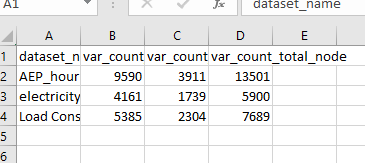

In [ ]:
chunk_size = len(dataframe)  # Define the chunk size
number_of_data_inserted=0
range_dict={}

final_result_data_groups, total_inserted = process_data_in_chunks(dataframe, chunk_size, CONSUMPTION_RANGES, n, get_range_index)


In [ ]:
len(final_result_data_groups) 

In [ ]:
dataframeORG=all_df.copy()
print(dataframeORG)

In [ ]:
dataframeORG=all_df.copy()
print(dataframeORG)
columns=['Size', 'Total Nodes', 'Artificial Nodes', 'Real Nodes',"execution_time"]

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=columns)
for size in range(10000, len(dataframeORG), 10000):
    start_time = time.time()

    dataframe=dataframeORG.copy()[:size]
    chunk_size = len(dataframe)  # Define the chunk size
    number_of_data_inserted=0
    range_dict={}

    final_result_data_groups, total_inserted = process_data_in_chunks(dataframe, chunk_size, CONSUMPTION_RANGES, 0, get_range_index)

    print("final_result_data_groups",len(final_result_data_groups))
    root=None
    p=None
    leafTree=None
    consumptionLevel=None
    cntDataBotLevelTree=[]
    cluster=[]

    for group in final_result_data_groups:
        user_input,_ = group[0]
        user_input = float(user_input)
        consumptionLevel =get_consumption_level(user_input,CONSUMPTION_RANGES)
        Insert (group,p,False)



    size_root , total_count = sizeof_tree(root) , countDataPointInTree(root)
    var_count_total_node , var_count_artificial_node , var_count_real_node     =     countTotalNode(root), countArtificialNode(root) , countRealNode(root)

    end_time = time.time()
    execution_time = end_time - start_time # Calculate the elapsed time

    # Append results to DataFrame
    print("__________________________________________________________")
    print("range of boucle:", size)
    print("countDataPointInTree",total_count)
    print("var_count_total_node",var_count_total_node)
    print("var_count_artificial_node",var_count_artificial_node)
    print("var_count_real_node",var_count_real_node)
    print("__________________________________________________________")
    results_df = pd.concat([
        results_df, 
        pd.DataFrame([[size, var_count_total_node, var_count_artificial_node, var_count_real_node,execution_time]], columns=columns)
    ], ignore_index=True)


# size_based_node_counts_results

# Save the results to a CSV file

output_dir = f"./output/{os.path.splitext(os.path.basename(CSV_FILE_PATH))[0]}"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, 'size_based_node_counts_results.csv')

results_df.to_csv(output_file_path, index=False)
print(f"size_based_node_counts_results saved successfully to {output_file_path}")



In [ ]:
print(results_df)

In [ ]:
# list(var_real)+list(var_artificial)+list(var_total)

In [ ]:
import pandas as pd

# Specify the path to your CSV file
file_path = 'output/AEP_hourly/dictionaries.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the column names
print("Columns in the CSV file:")
print(df.columns.tolist())


In [ ]:
# Keep only the first and last columns
df = df.iloc[:, [0, -1]]

# Display the updated DataFrame
print("Updated DataFrame:")
print(df)

# Display the updated DataFrame columns
print("Updated DataFrame columns:")
print(df.columns.tolist())


In [ ]:
df

In [ ]:

# Generate the new dataset
expanded_data = []
for _, row in df.iterrows():
    expanded_data.extend([row['consumption']] * row['count in level all'])

# Create a new DataFrame with the expanded data
expanded_df = pd.DataFrame({'consumption': expanded_data})

# Display the result
print(expanded_df)


In [ ]:
sum(df['count in level all'])

In [ ]:
import pandas as pd

# Assuming expanded_df is already defined
# Replace 'expanded_data.xlsx' with your desired file name

# output_dir = f"./output/{os.path.splitext(os.path.basename(CSV_FILE_PATH))[0]}"
# os.makedirs(output_dir, exist_ok=True)
# output_file_path = os.path.join(output_dir, 'expanded_data.xlsx')
output_file_path = 'output/AEP_hourly/expanded_data.xlsx'
# Save the DataFrame to an Excel file
expanded_df.to_excel(output_file_path, index=False)

# Confirm the save
print(f"DataFrame saved to {output_file_path}")


In [ ]:
vars(root.right.right)
     